In [ ]:
def VisualizingDataset(X_, Y_):
  X1 = X_[:, 0]
  X2 = X_[:, 1]
  for i, label in enumerate(np.unique(Y_)):
    plt.scatter(X1[Y_ == label], X2[Y_ == label])
  plt.show()

# Import library

In [3]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.5 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import openmeteo_requests
import requests_cache
from retry_requests import retry
from datetime import date, datetime
from dateutil.relativedelta import *
import joblib

Read .csv file and split it to 2 np array:

date contain the date of samples

data contain the features of samples

In [ ]:
random_state = 69
data_path = "/content/drive/MyDrive/SE355/DoAn/Data/"

In [ ]:
csv_path = data_path + "dataset.csv"
df = pd.read_csv(csv_path)
df.head()
date = df.iloc[:, 0:1].to_numpy()
data = df.iloc[:, 1:-3].to_numpy().astype(np.float32)
predict_rain = df.iloc[:, -3].to_numpy().flatten().astype(np.int8)
predict_heat = df.iloc[:, -2].to_numpy().flatten().astype(np.int8)
predict_cloud = df.iloc[:, -1].to_numpy().flatten().astype(np.int8)

# Plot label's distribution

[0 1] [20869  3779]


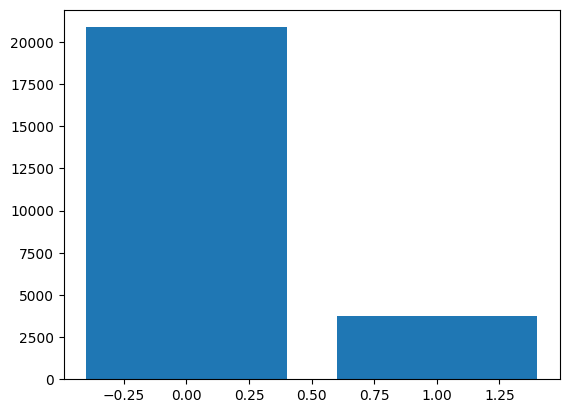

[0 1] [16643  8005]


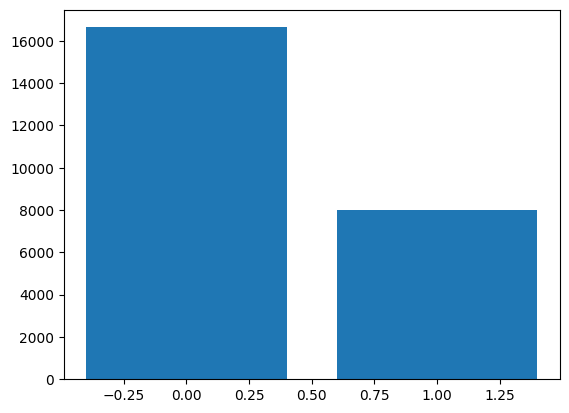

[0 1 2] [20979  2118  1551]


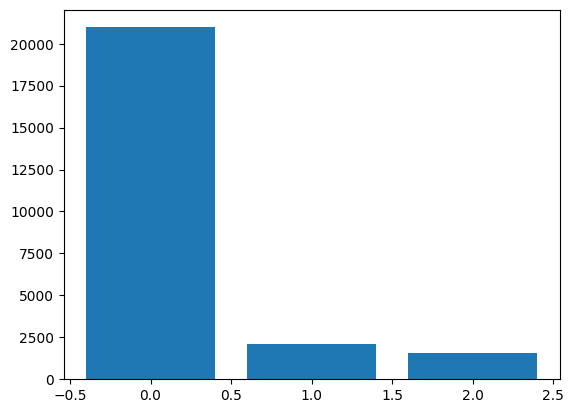

In [ ]:
#labels: list of data points' label
#use to plot the number of each label
def plot_labels(labels):
  unique_labels, counts = np.unique(labels, return_counts=True)
  print(unique_labels, counts)
  plt.bar(unique_labels, counts)
  plt.show()

plot_labels(predict_rain)
plot_labels(predict_cloud)
plot_labels(predict_heat)

In [ ]:
#labels: list of data points'label
#return the data points' index after undersampling
def undersampling(labels, random_state):
  unique_labels, counts = np.unique(labels, return_counts=True)
  min_size = min(counts)
  final_indices = []
  for la in unique_labels:
    indices = np.where(labels==la)
    np.random.seed(random_state)
    indices = np.random.choice(indices[0], size=min_size)
    final_indices.append(indices)
  return np.array(final_indices).flatten()

# Rain predict model

In [ ]:
rain_idx = undersampling(predict_rain, random_state)
rain_data, rain_labels = data[rain_idx], predict_rain[rain_idx]
rain_classes = np.unique(predict_rain)

[0 1] [3779 3779]


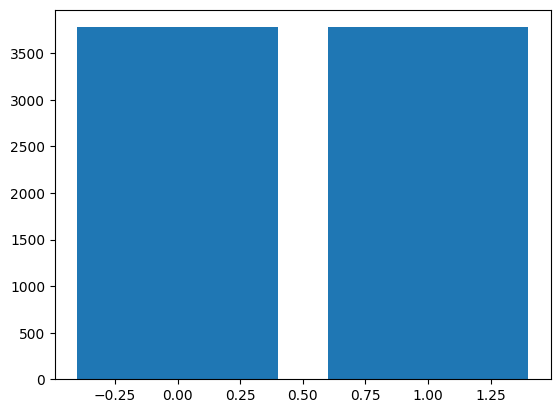

In [ ]:
#data point after undersampling
plot_labels(rain_labels)

In [ ]:
X_train_rain, X_test_rain, Y_train_rain, Y_test_rain = train_test_split(rain_data, rain_labels, train_size=0.8, random_state=random_state)

choose the number of component to extract with pca

In [ ]:
scaler = StandardScaler()
X_train_rain_scaled = scaler.fit_transform(X_train_rain)
numbers = [10, 50, 100, 200, 300, 500, 1000, 2000, 3000]
info_ratio = []
for n in numbers:
  pca = PCA(n_components=n)
  pca.fit(X_train_rain_scaled)
  info_ratio.append(sum(pca.explained_variance_ratio_))

In [ ]:
for n, ir in zip(numbers, info_ratio):
  print(n, ir)

10 0.33327684737741947
50 0.5282930408138782
100 0.6420404841192067
200 0.7522217609221116
300 0.8138007247180212
500 0.8854492877435405
1000 0.9598598161610425
2000 0.9959142071593305
3000 0.9997696052736273


info_ratio = [0.3244775803759694,
 0.5152207068167627,
 0.6274218398611993,
 0.734519753663335,
 0.8659822312474716,
 0.9456921817472903,
 0.9923077647799801,
 0.9993621863479802,
 0.999942010548267]

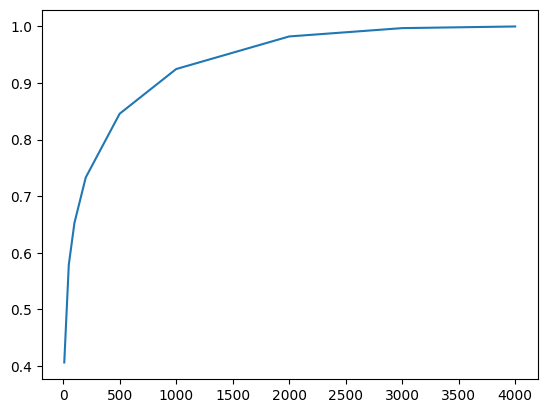

In [ ]:
plt.plot(numbers, info_ratio)

In [ ]:
def pca_scaler(X_train, X_test, pca_components):
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  pca = PCA(n_components=pca_components)
  X_train_pca = pca.fit_transform(X_train_scaled).astype(np.float32)
  X_test_pca = pca.transform(X_test_scaled).astype(np.float32)

  return X_train_pca, X_test_pca, pca, scaler

In [ ]:
X_train_rain_pca, X_test_rain_pca, rain_pca, rain_sc = pca_scaler(X_train_rain, X_test_rain, 500)

In [ ]:
joblib.dump(rain_pca, data_path + "rain_pca.joblib")
joblib.dump(rain_sc, data_path + "rain_sc.joblib")

['/content/drive/MyDrive/SE355/DoAn/Data/rain_sc.joblib']

In [ ]:
def logistic(X_train, Y_train, X_test):
  logis = LogisticRegression()
  logis.fit(X_train, Y_train)
  train_pred = logis.predict(X_train)
  test_pred = logis.predict(X_test)
  return train_pred, test_pred, logis

In [ ]:
rain_train_pred, rain_test_pred, rain_logis= logistic(X_train_rain_pca, Y_train_rain, X_test_rain_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
def cm_display(true_labels, pred_labels, classes):
  cm = confusion_matrix(true_labels, pred_labels, labels=classes)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  disp.plot()
  plt.show()

def train_test_cm_display(train_labels, train_pred, test_labels, test_pred, classes):
  print("Train confusion matrix:")
  cm_display(train_labels, train_pred, classes)
  print("\n\nTest confusion matrix:")
  cm_display(test_labels, test_pred, classes)

Train confusion matrix:


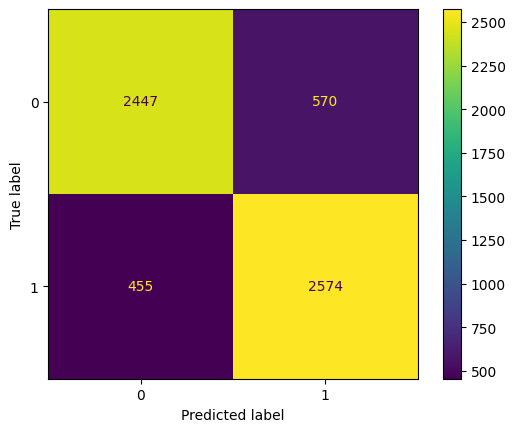



Test confusion matrix:


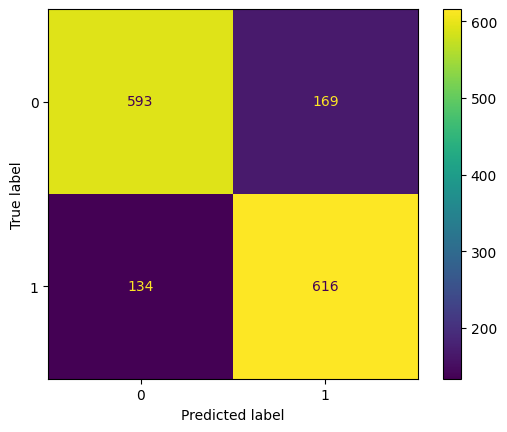

In [ ]:
train_test_cm_display(Y_train_rain, rain_train_pred, Y_test_rain, rain_test_pred, rain_classes)

In [ ]:
def f1_score_display(Y_train, train_pred, Y_test, test_pred):
  train_f1 = f1_score(Y_train, train_pred, average="macro")
  test_f1 = f1_score(Y_test, test_pred, average="macro")
  print(train_f1)
  print(test_f1)

In [ ]:
f1_score_display(Y_train_rain, rain_train_pred, Y_test_rain, rain_test_pred)

0.8303915867067335
0.7995567932482068


In [ ]:
def svc_with_kernel(kernel, X_train, Y_train, X_test):
  svc = SVC(kernel= kernel)
  svc.fit(X_train, Y_train)
  train_pred = svc.predict(X_train)
  test_pred = svc.predict(X_test)
  return train_pred, test_pred, svc

In [ ]:
rain_train_pred, rain_test_pred, rain_svc = svc_with_kernel("rbf", X_train_rain_pca, Y_train_rain, X_test_rain_pca)

Train confusion matrix:


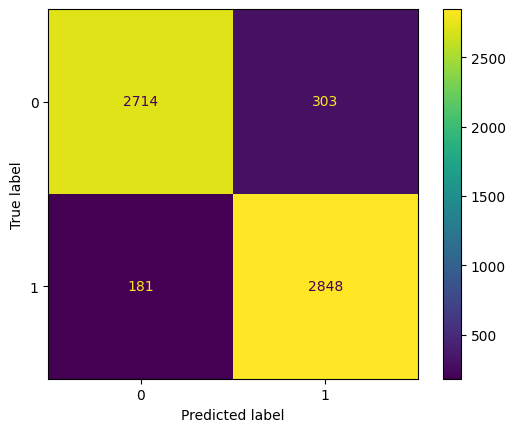



Test confusion matrix:


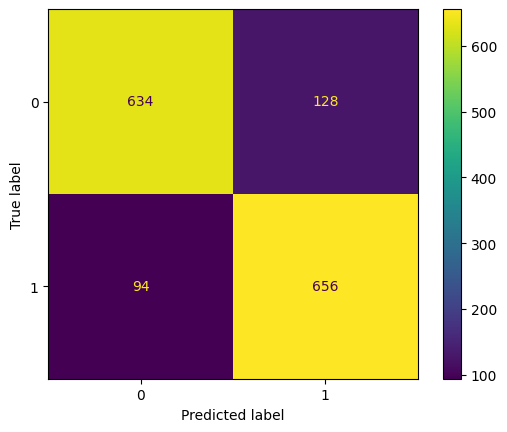

In [ ]:
train_test_cm_display(Y_train_rain, rain_train_pred, Y_test_rain, rain_test_pred, rain_classes)

In [ ]:
f1_score_display(Y_train_rain, rain_train_pred, Y_test_rain, rain_test_pred)

0.9199077297668938
0.8531435121584137


In [ ]:
def random_forest(X_train, Y_train, X_test, ran_estimators, ran_depth):
  ran_forest = RandomForestClassifier(n_estimators=ran_estimators, max_depth=ran_depth, random_state=random_state)
  ran_forest.fit(X_train, Y_train)
  train_pred = ran_forest.predict(X_train)
  test_pred = ran_forest.predict(X_test)
  return train_pred, test_pred, ran_forest

In [ ]:
rain_train_pred, rain_test_pred, rain_rf = random_forest(X_train_rain_pca, Y_train_rain, X_test_rain_pca, 200, 22)

In [ ]:
joblib.dump(rain_rf, data_path + "rain_rf.joblib")

['/content/drive/MyDrive/SE355/DoAn/Data/rain_rf.joblib']

Train confusion matrix:


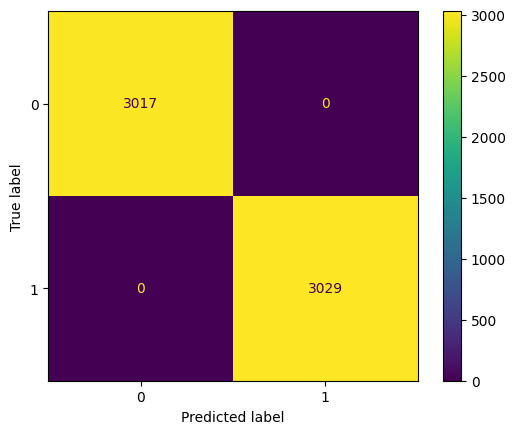



Test confusion matrix:


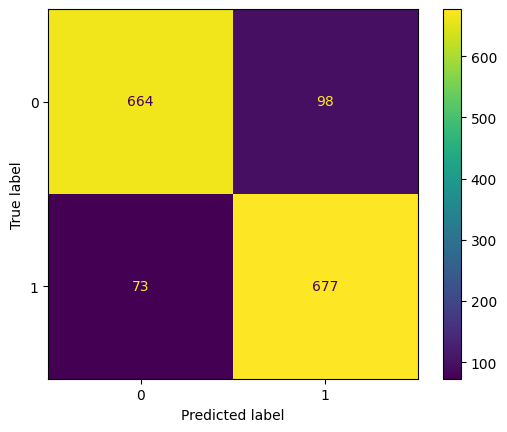

In [ ]:
train_test_cm_display(Y_train_rain, rain_train_pred, Y_test_rain, rain_test_pred, rain_classes)

In [ ]:
f1_score_display(Y_train_rain, rain_train_pred, Y_test_rain, rain_test_pred)

1.0
0.8868964008792748


# Heat predict model

In [ ]:
heat_idx = undersampling(predict_heat, random_state)
heat_data, heat_labels = data[heat_idx], predict_heat[heat_idx]
heat_classes = np.unique(predict_heat)

[0 1 2] [1551 1551 1551]


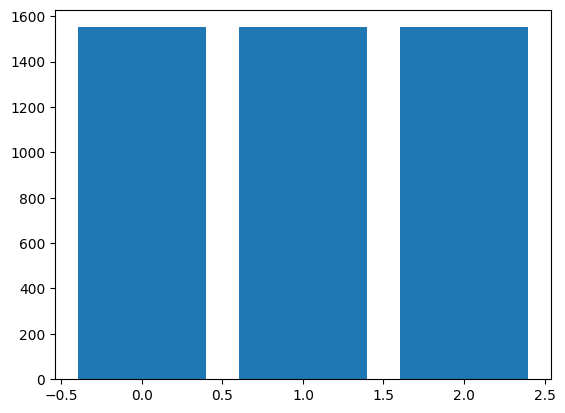

In [ ]:
#data point after undersampling
plot_labels(heat_labels)

In [ ]:
X_train_heat, X_test_heat, Y_train_heat, Y_test_heat = train_test_split(heat_data, heat_labels, train_size=0.8, random_state=random_state)

choose the number of component to extract with pca

In [ ]:
scaler = StandardScaler()
X_train_heat_scaled = scaler.fit_transform(X_train_heat)
numbers = [10, 50, 100, 200, 300, 500, 1000, 2000, 3000]
info_ratio = []
for n in numbers:
  pca = PCA(n_components=n)
  pca.fit(X_train_heat_scaled)
  info_ratio.append(sum(pca.explained_variance_ratio_))

In [ ]:
for n, ir in zip(numbers, info_ratio):
  print(n, ir)

10 0.3428170308470726
50 0.5423535371664912
100 0.6556849627522752
200 0.7680918190744705
300 0.8313702394370921
500 0.9029920285975095
1000 0.9718888479437737
2000 0.9983865522167434
3000 0.9999999412614491


10 0.3428170308470726
50 0.5423535371664912
100 0.6556849627522752
200 0.7680918190744705
300 0.8313702394370921
500 0.9029920285975095
1000 0.9718888479437737
2000 0.9983865522167434
3000 0.9999999412614491

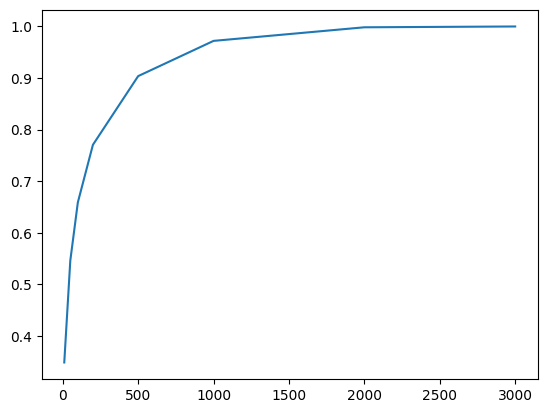

In [ ]:
plt.plot(numbers, info_ratio)

PCA & standard scaler

In [ ]:
X_train_heat_pca, X_test_heat_pca, heat_pca, heat_sc = pca_scaler(X_train_heat, X_test_heat, 350)

In [ ]:
joblib.dump(heat_pca, data_path + "heat_pca.joblib")
joblib.dump(heat_sc, data_path + "heat_sc.joblib")

['/content/drive/MyDrive/SE355/DoAn/Data/heat_sc.joblib']

Softmax regression

In [ ]:
heat_train_pred, heat_test_pred, heat_logis = logistic(X_train_heat_pca, Y_train_heat, X_test_heat_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train confusion matrix:


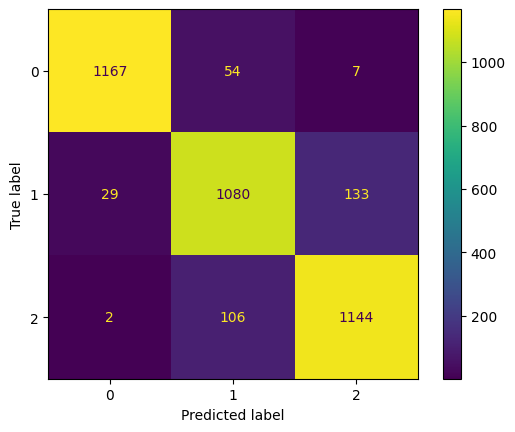



Test confusion matrix:


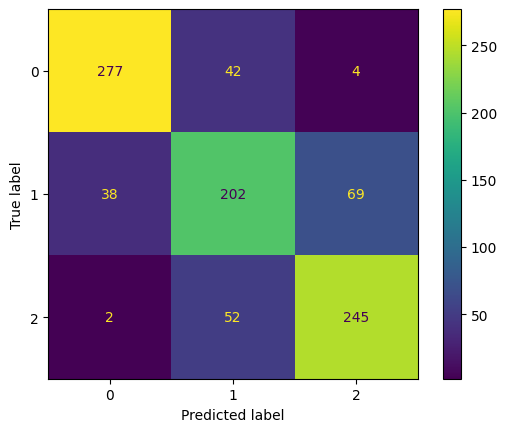

In [ ]:
train_test_cm_display(Y_train_heat, heat_train_pred, Y_test_heat, heat_test_pred, heat_classes)

In [ ]:
f1_score_display(Y_train_heat, heat_train_pred, Y_test_heat, heat_test_pred)

0.9115172034315798
0.7758529703622344


SVM

In [ ]:
heat_train_pred, heat_test_pred, heat_svc = svc_with_kernel("rbf", X_train_heat_pca, Y_train_heat, X_test_heat_pca)

Train confusion matrix:


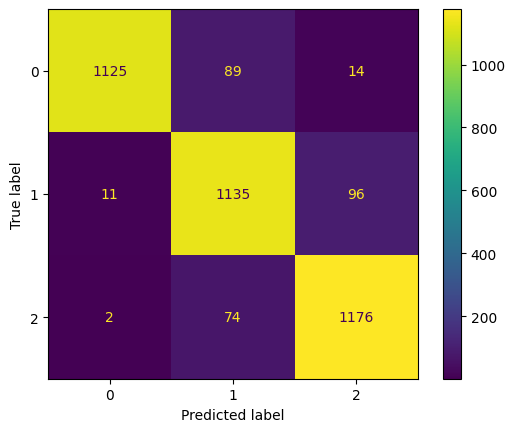



Test confusion matrix:


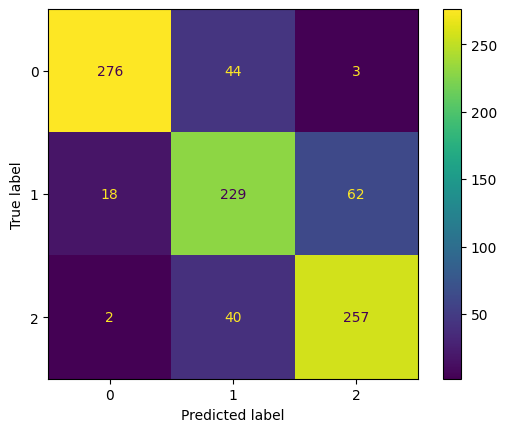

In [ ]:
train_test_cm_display(Y_train_heat, heat_train_pred, Y_test_heat, heat_test_pred, heat_classes)

In [ ]:
f1_score_display(Y_train_heat, heat_train_pred, Y_test_heat, heat_test_pred)

0.9237956134034592
0.8185975241031804


In [ ]:
joblib.dump(heat_svc, data_path + "heat_svc.joblib")

['/content/drive/MyDrive/SE355/DoAn/Data/heat_svc.joblib']

random forest

In [ ]:
heat_train_pred, heat_test_pred, heat_rf = random_forest(X_train_heat_pca, Y_train_heat, X_test_heat_pca, 150, 22)

Train confusion matrix:


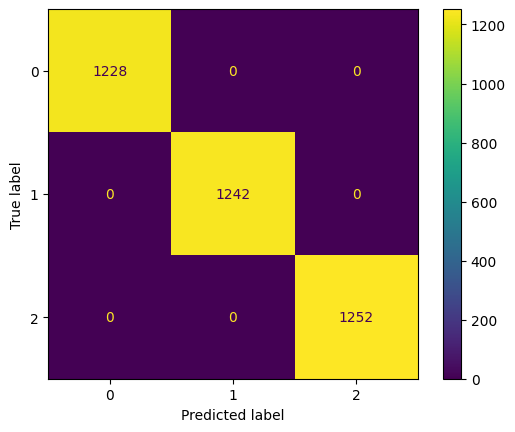



Test confusion matrix:


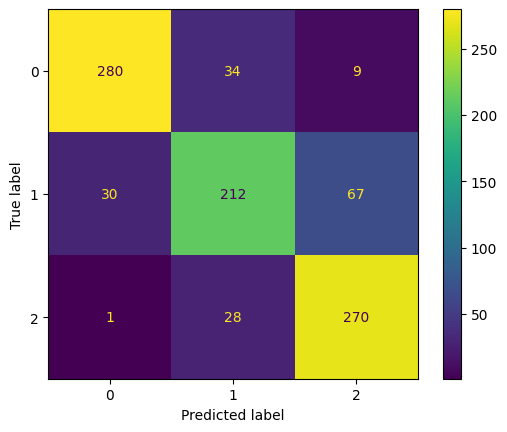

In [ ]:
train_test_cm_display(Y_train_heat, heat_train_pred, Y_test_heat, heat_test_pred, heat_classes)

In [ ]:
f1_score_display(Y_train_heat, heat_train_pred, Y_test_heat, heat_test_pred)

1.0
0.8159209288987


# Predict cloud cover

In [ ]:
cloud_idx = undersampling(predict_cloud, random_state)
cloud_data, cloud_labels = data[cloud_idx], predict_cloud[cloud_idx]
cloud_classes = np.unique(predict_cloud)

[0 1] [8005 8005]


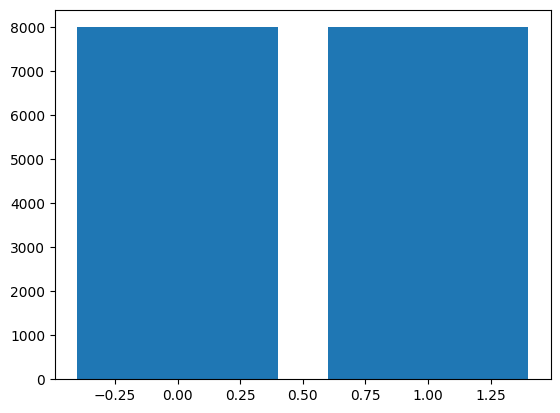

In [ ]:
#data point after undersampling
plot_labels(cloud_labels)

In [ ]:
X_train_cloud, X_test_cloud, Y_train_cloud, Y_test_cloud = train_test_split(cloud_data, cloud_labels, train_size=0.8, random_state=random_state)

choose the number of component to extract with pca

In [ ]:
numbers = [10, 50, 100, 200, 500, 1000, 2000, 3000, 4000]
info_ratio = []
for n in numbers:
  pca = PCA(n_components=n)
  pca.fit(X_train_cloud)
  info_ratio.append(sum(pca.explained_variance_ratio_))

In [ ]:
print(info_ratio)

[0.32827975507825613, 0.5211429537739605, 0.6339239132357761, 0.7425934176426381, 0.8749012955231592, 0.9519915169366868, 0.9938116899293163, 0.9995263105461163, 0.9999621277957189]


info_ratio = [0.32557917200028896, 0.519470531726256, 0.6327587414998561, 0.7413287366507575, 0.8741259582457133, 0.9517678496995359, 0.993821409812881, 0.9995279015609526, 0.9999620209099831]


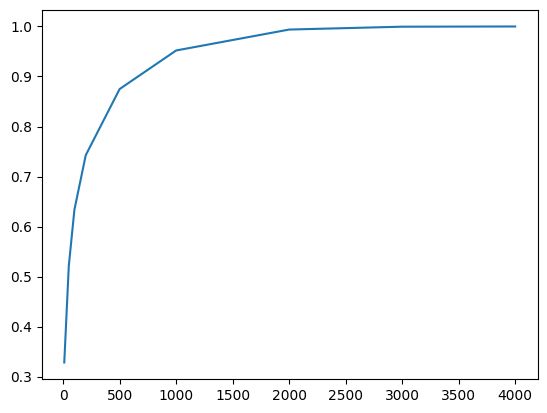

In [ ]:
plt.plot(numbers, info_ratio)

In [ ]:
X_train_cloud_pca, X_test_cloud_pca, cloud_pca, cloud_sc = pca_scaler(X_train_cloud, X_test_cloud, 500)

In [ ]:
joblib.dump(cloud_pca, data_path + "cloud_pca.joblib")
joblib.dump(cloud_sc, data_path + "cloud_sc.joblib")

['/content/drive/MyDrive/SE355/DoAn/Data/cloud_sc.joblib']

Softmax regression

In [ ]:
cloud_train_pred, cloud_test_pred, cloud_logis = logistic(X_train_cloud_pca, Y_train_cloud, X_test_cloud_pca)

Train confusion matrix:


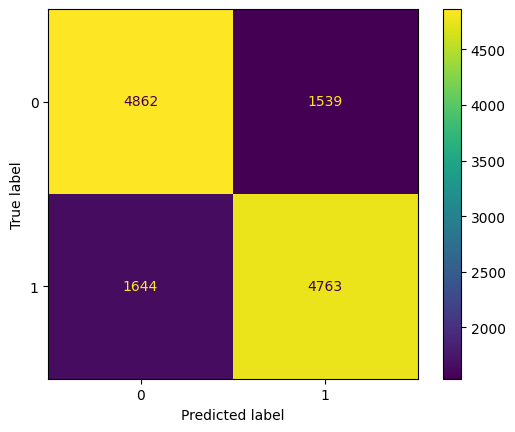



Test confusion matrix:


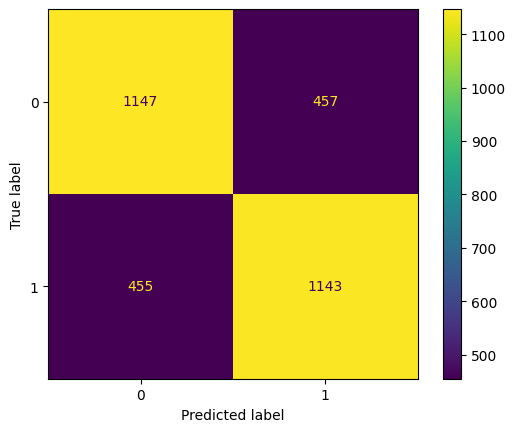

In [ ]:
train_test_cm_display(Y_train_cloud, cloud_train_pred, Y_test_cloud, cloud_test_pred, cloud_classes)

In [ ]:
f1_score_display(Y_train_cloud, cloud_train_pred, Y_test_cloud, cloud_test_pred)

0.7514685991250543
0.7151775692621363


SVM

In [ ]:
cloud_train_pred, cloud_test_pred, cloud_svc = svc_with_kernel("rbf", X_train_cloud_pca, Y_train_cloud, X_test_cloud_pca)

Train confusion matrix:


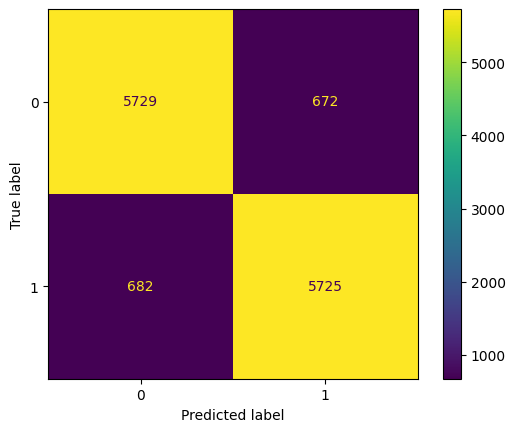



Test confusion matrix:


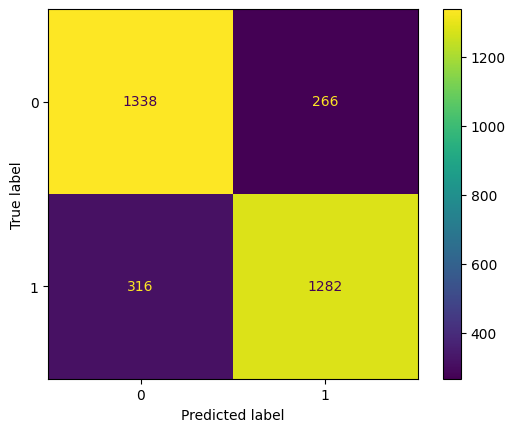

In [ ]:
train_test_cm_display(Y_train_cloud, cloud_train_pred, Y_test_cloud, cloud_test_pred, cloud_classes)

In [ ]:
f1_score_display(Y_train_cloud, cloud_train_pred, Y_test_cloud, cloud_test_pred)

0.8942848116754023
0.8181829889514469


Random forest

In [ ]:
cloud_train_pred, cloud_test_pred, cloud_rf = random_forest(X_train_cloud_pca, Y_train_cloud, X_test_cloud_pca, 200, 22)

In [ ]:
joblib.dump(cloud_rf, data_path + "cloud_rf.joblib")

['/content/drive/MyDrive/SE355/DoAn/Data/cloud_rf.joblib']

Train confusion matrix:


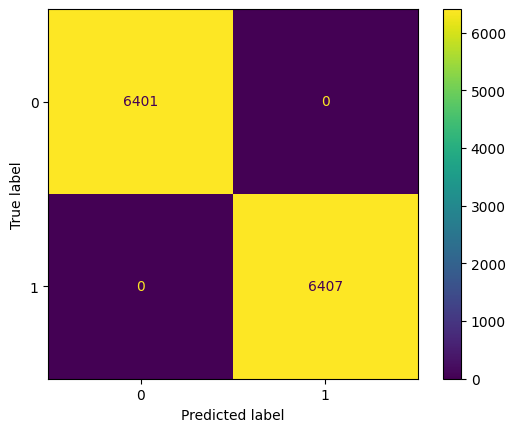



Test confusion matrix:


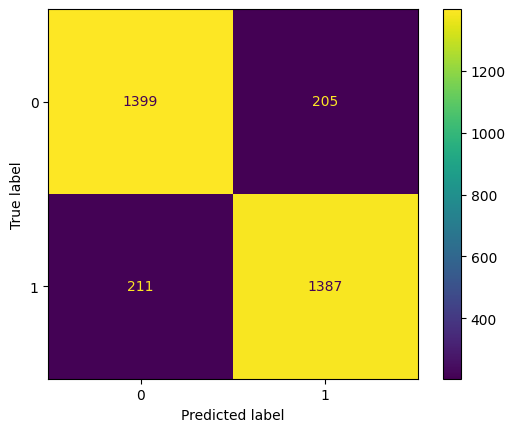

In [ ]:
train_test_cm_display(Y_train_cloud, cloud_train_pred, Y_test_cloud, cloud_test_pred, cloud_classes)

In [ ]:
f1_score_display(Y_train_cloud, cloud_train_pred, Y_test_cloud, cloud_test_pred)

1.0
0.8700793745232944


# Demo

In [15]:
def get_weather_feats(lat, long, start_date, end_date):
	# Setup the Open-Meteo API client with cache and retry on error
  cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
  retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
  openmeteo = openmeteo_requests.Client(session = retry_session)
  hourly_feats = ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "apparent_temperature",
                  "rain", "pressure_msl", "surface_pressure", "cloud_cover", "cloud_cover_low", "cloud_cover_mid",
                  "cloud_cover_high", "wind_speed_10m", "wind_speed_100m", "wind_direction_10m", "wind_direction_100m", "wind_gusts_10m"]
  # Make sure all required weather variables are listed here
  # The order of variables in hourly or daily is important to assign them correctly below
  url = "https://archive-api.open-meteo.com/v1/archive"
  params = {
    "latitude": lat,
    "longitude": long,
    "start_date": start_date,
    "end_date": end_date,
    "hourly": hourly_feats,
    # "timezone": "Asia/Bangkok"
  }

  responses = openmeteo.weather_api(url, params=params)

  # Process first location. Add a for-loop for multiple locations or weather models
  response = responses[0]
  # print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
  # print(f"Elevation {response.Elevation()} m asl")
  # print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
  # print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

  # Process hourly data. The order of variables needs to be the same as requested.
  hourly = response.Hourly()
  hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s"),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
  )}

  for i, feat in enumerate(hourly_feats):
    hourly_data[feat] = hourly.Variables(i).ValuesAsNumpy()

  hourly_dataframe = pd.DataFrame(data = hourly_data)
  return hourly_dataframe

In [10]:
q1_lat, q1_long = 10.7807, 106.6994
current_date = datetime.today() - relativedelta(days=2)
current_date = current_date.isoformat().split("T")[0]
print("current_date")

2023-12-23


In [16]:
test = "2023-12-23"
hourly_df = get_weather_feats(q1_lat, q1_long, test, test)
hourly_df.head(24)

,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,rain,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m
0,2023-12-23 00:00:00,24.489500,65.655739,17.639500,25.303284,0.0,1014.000000,1011.907837,90.000008,0.0,100.0,100.0,13.276144,24.448214,12.528798,13.627024,23.400000
1,2023-12-23 01:00:00,25.139500,67.249718,18.639500,26.707281,0.0,1014.799988,1012.710632,90.000008,0.0,100.0,100.0,11.212135,16.559999,354.472534,360.000000,18.000000
2,2023-12-23 02:00:00,26.239500,63.595459,18.789499,27.551266,0.0,1015.200012,1013.117432,69.900002,0.0,67.0,99.0,13.441071,18.391735,352.304047,356.633606,21.959999
3,2023-12-23 03:00:00,27.539499,59.656425,18.989500,29.040123,0.0,1015.000000,1012.926697,20.100002,0.0,19.0,29.0,12.783802,16.299694,350.272491,353.659912,24.840000
4,2023-12-23 04:00:00,28.989500,56.387268,19.439499,31.179478,0.0,1014.599976,1012.537659,20.700001,0.0,24.0,21.0,13.849476,16.700275,351.027435,352.568695,26.280001
5,2023-12-23 05:00:00,30.939499,50.096413,19.339500,33.910789,0.0,1013.500000,1011.452881,62.100002,40.0,29.0,29.0,13.324863,16.215992,1.548122,2.544756,27.359999
6,2023-12-23 06:00:00,31.989498,46.031807,18.939499,34.114876,0.0,1012.599976,1010.561890,100.000000,85.0,24.0,31.0,14.255272,17.057314,44.999897,45.855011,28.080000
7,2023-12-23 07:00:00,32.589500,44.915600,19.089500,33.392406,0.0,1011.400024,1009.368225,63.299999,42.0,39.0,7.0,17.848160,22.183128,48.270576,48.289345,29.879999
8,2023-12-23 08:00:00,31.389500,47.477875,18.889500,32.020432,0.0,1011.200012,1009.160645,50.700005,18.0,56.0,3.0,18.388212,23.540806,23.051332,23.428713,32.399998
9,2023-12-23 09:00:00,30.289499,49.772243,18.639500,30.499783,0.0,1011.299988,1009.253235,100.000000,97.0,37.0,48.0,20.478907,27.534704,10.124612,11.309896,31.319998


In [ ]:
def get_last_year_week(date):
  date_list = []
  seven_days = 7*24
  deltas = [-seven_days, -1, 1, seven_days]
  date_milestone = []
  for delta in deltas:
    milestone = date + relativedelta(years= -1, hours= delta)
    date_milestone.append(str(milestone))
  return date_milestone

def get_last_week(date):
  week_far = date + relativedelta(days= -3)
  week_near = date + relativedelta(days= -9)
  return week_near, week_far

def get_week_data(data, time_near, time_far):
  pos1 = np.flatnonzero(data["date"].to_numpy() == time_near)[0]
  pos2 = np.flatnonzero(data["date"].to_numpy() == time_far)[0]
  return data.iloc[pos1:pos2+1, 1:].to_numpy(copy=True).flatten()

def build_data(date, lat, long):
  week_near, week_far = get_last_week(date)
  last_week_df = get_weather_feats(lat, long, week_near.date(), week_far.date())
  last_week_feats = last_week_df.iloc[:, 1:].to_numpy().flatten()

  ly_near_milestone = date + relativedelta(years= -1, hours= -(24*7))
  ly_far_milestone = date + relativedelta(years= -1, hours= 23 + 24*7)
  last_year_df = get_weather_feats(lat, long, ly_near_milestone.date(),
                                  ly_far_milestone.date())
  data = []
  hours = []
  last_year_df["date"] = last_year_df["date"].astype(str)
  for i in range(0, 24):
    hour = date + relativedelta(hours= i)
    ly_ms = get_last_year_week(hour)
    ly_before_feats = get_week_data(last_year_df, ly_ms[0], ly_ms[1])
    ly_after_feats = get_week_data(last_year_df, ly_ms[2], ly_ms[3])
    features = np.concatenate([last_week_feats, ly_before_feats, ly_after_feats])
    data.append(features)
    hours.append(str(hour))
  return np.array(data), hours

today = datetime.fromisoformat(str(datetime.now().date()))
today_data, hours = build_data(today, q1_lat, q1_long)

In [ ]:
test = get_weather_feats(q1_lat, q1_long, current_date, current_date)
test.head()

,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,rain,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m
0,2023-12-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-12-23 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-12-23 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-12-23 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-12-23 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def load_model(data_path):
  rain_sc = joblib.load(data_path + "rain_sc.joblib")
  rain_pca = joblib.load(data_path + "rain_pca.joblib")
  rain_rf = joblib.load(data_path + "rain_rf.joblib")

  heat_sc = joblib.load(data_path + "heat_sc.joblib")
  heat_pca = joblib.load(data_path + "heat_pca.joblib")
  heat_svc = joblib.load(data_path + "heat_svc.joblib")

  cloud_sc = joblib.load(data_path + "cloud_sc.joblib")
  cloud_pca = joblib.load(data_path + "cloud_pca.joblib")
  cloud_rf = joblib.load(data_path + "cloud_rf.joblib")

  return (rain_sc, rain_pca, rain_rf,
          heat_sc, heat_pca, heat_svc,
          cloud_sc, cloud_pca, cloud_rf)

In [ ]:
def weather_forecast(data_path, today_data):
  (rain_sc, rain_pca, rain_rf,
  heat_sc, heat_pca, heat_svc,
  cloud_sc, cloud_pca, cloud_rf) = load_model(data_path)

  data_scaled = rain_sc.transform(today_data)
  data_pca = rain_pca.transform(data_scaled)
  rain_pred = rain_rf.predict(data_pca)

  data_scaled = heat_sc.transform(today_data)
  data_pca = heat_pca.transform(data_scaled)
  heat_pred = heat_svc.predict(data_pca)

  data_scaled = cloud_sc.transform(today_data)
  data_pca = cloud_pca.transform(data_scaled)
  cloud_pred = cloud_rf.predict(data_pca)
  return [rain_pred, heat_pred, cloud_pred]

predict = weather_forecast(data_path, today_data)

In [ ]:
print(predict)

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int8), array([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int8), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int8)]


In [ ]:
rain_status = ["Không mưa", "Mưa"]
heat_status = ["Mát", "Nóng", "Nóng gay gắt"]
cloud_status = ["Ít mây", "Nhiều mây"]
for i in range(0, 24):
  print(hours[i], ":")
  print(rain_status[predict[0][i]])
  print(heat_status[predict[1][i]])
  print(cloud_status[predict[2][i]])

2023-12-25 00:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 01:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 02:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 03:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 04:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 05:00:00 :
Không mưa
Nóng
Ít mây
2023-12-25 06:00:00 :
Không mưa
Nóng
Ít mây
2023-12-25 07:00:00 :
Không mưa
Nóng
Ít mây
2023-12-25 08:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 09:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 10:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 11:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 12:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 13:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 14:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 15:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 16:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 17:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 18:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 19:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 20:00:00 :
Không mưa
Mát
Ít mây
2023-12-25 21:00:00 :
Không mưa
Mát
Ít mây
2023-12